# Это Страница с решением задания №2

### Вопрос: 
- Выяви самый сложный и самый простой экзамен
- Найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью. 

- Завершаемость = кол-во успешных экзов / общее кол-во попыток сдать экз

### Основная логика действий:

1. Создаем отдельный дата-сет для тех, кто сдавал экзамен (условие в задании: выявить самый простой и сложный экзамен)
2. Посмотреть студентов, кто не сдавал экзамены (не зарегистрировался на него) 
3. Посмотреть, есть ли пересдачники на экзамене 
4. Посмотреть на студентов, у кого оценка NA за экзамен
5. Посмотреть процент завершаемости экзаменов у студентов – семестр / предмет 
6. Посмотреть процент завершаемости экзаменов у студентов – семестр 
7. Посмотреть процент завершаемости экзаменов у студентов – предмет
8. Посмотреть связь семестра / предмета / семестра + предмета с успешной сдачей экзамена (хи-тест)


### Либы + настройки для графиков

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

sns.set(rc={'figure.figsize':(10,7)})

### Грузим дата-сеты 

In [2]:
#Качаем дата-сеты
assesments = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/assessments.csv')
courses = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/courses.csv')
student_assesment = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentAssessment.csv')
student_registration = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentRegistration.csv')

#Связываем дата-сеты
courses_reg = pd.merge(courses,student_registration,on=['code_module', 'code_presentation'])
ocenki = pd.merge(courses_reg, assesments,on= ['code_module', 'code_presentation'])
full_ocenki = pd.merge(ocenki, student_assesment,on=['id_assessment', 'id_student'])

### Создаем дата-сет со студентами, которые сдавали экз

In [5]:
#Список критерий
examini = full_ocenki[full_ocenki['assessment_type'] == "Exam"].id_student.unique().tolist()

#Дата-сет с экзаменами
examin_data = full_ocenki[full_ocenki.id_student.isin(examini)]

### Выявляем студента, кто дропнулся с предмета

In [6]:
examin_data.query('date_unregistration == date_unregistration & score == score & assessment_type == "Exam"')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score
66767,DDD,2013J,261,425543,-39.0,232.0,25354,Exam,261.0,100.0,237,0,33.0


Удаляем его!

In [7]:
#Дропнутый студент
dropped_student = [425543]

#Удаление
examin_data_new = examin_data[~examin_data.id_student.isin(dropped_student)]

### Есть ли пересдачники?

In [8]:
examin_data.query('is_banked == 1 & assessment_type == "Exam"')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score


Никто не пересдавал экзамены. Молодцы...

### У нас в данных много студентов, кто не сдавал тесты (не зарегался), но сдавали экзамены. Это ок?

In [9]:
examin_data_new.query('date_unregistration == date_unregistration').id_student.nunique()

247

Таких студентов у нас 247

Возможно они сдавали несколько предметов. По одному получилось сдать экз. А другой дропнули  
Или сдавали какие то тесты в одном семестре - не получилось и дропнулись. И сдали предмет в другом семестре 

In [13]:
examin_data_new.query('id_student == 29411')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score
46207,CCC,2014J,269,29411,-135.0,100.0,24295,CMA,18.0,2.0,21,0,0.0
46208,CCC,2014J,269,29411,-135.0,100.0,24291,TMA,32.0,9.0,51,0,14.0
65139,DDD,2013J,261,29411,-96.0,NaN,25348,TMA,25.0,10.0,24,0,75.0
65140,DDD,2013J,261,29411,-96.0,NaN,25349,TMA,53.0,12.5,53,0,79.0
65141,DDD,2013J,261,29411,-96.0,NaN,25350,TMA,88.0,17.5,88,0,93.0
65142,DDD,2013J,261,29411,-96.0,NaN,25351,TMA,123.0,20.0,130,0,58.0
65143,DDD,2013J,261,29411,-96.0,NaN,25352,TMA,165.0,20.0,163,0,86.0
65144,DDD,2013J,261,29411,-96.0,NaN,25353,TMA,207.0,20.0,207,0,66.0
65145,DDD,2013J,261,29411,-96.0,NaN,25354,Exam,261.0,100.0,237,0,62.0


In [17]:
#Создаем отдельно дата-сет со студентами, у кого была отмена регистрации на тест, но успешно сданный экзамен
check_drop = examin_data_new.query('date_unregistration == date_unregistration').id_student.unique().tolist()
check_drop_data = examin_data_new[examin_data_new.id_student.isin(check_drop)]

#Создаем колонку – экзамен(1) | тест (0)
check_drop_data['is_ex'] = np.where(check_drop_data['assessment_type'] == "Exam", 1, 0).tolist()

#Сабсет студентов: по количество тесту и бинарной колонке – экзамен (1) и тест (0): is_ex
check_drop_data.groupby(['id_student', 'code_module', 'code_presentation'], as_index = False) \
    .agg({'assessment_type' : 'count',
         'is_ex' : 'sum'})

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_student,code_module,code_presentation,assessment_type,is_ex
0,29411,CCC,2014J,2,0
1,29411,DDD,2013J,7,1
2,40419,DDD,2013B,2,0
3,40419,DDD,2013J,7,1
4,45664,CCC,2014B,3,0
...,...,...,...,...,...
528,2646737,DDD,2014J,7,1
529,2668106,CCC,2014J,9,1
530,2668106,DDD,2014B,3,0
531,2668945,DDD,2013J,3,0


Рассмотрим последний сабсет. Только с условием, что is_ex == 0. И посчитаем кол-во студентов.

In [26]:
#Посмотрим на кол-во студентов, кто дропнулся с предмета и сдавал тесты  
check_drop_data.groupby(['id_student', 'code_module', 'code_presentation', 'date_registration'], as_index = False) \
    .agg({'assessment_type' : 'count',
         'is_ex' : 'sum'}).query('is_ex == 0 & date_registration == date_registration').id_student.nunique()

247

А теперь посмотрим на общее кол-во студентов в первоначальном дата-сете

In [27]:
check_drop_data.id_student.nunique()

247

Количество одинаковое!  
Это подтверждает мою гипотезу о том, что студенты сдавали 2 предмета:
- на первом они сдали какое-то кол-во тестов и дропнулись
- а второй предмет полностью (вместе с экз) сдали 

Вывод: все ок, студенты проходили тестики в других предметах и дропнулись   
Или сдавали один и тот же предмет в разных семестрах: в одном дропнулись, а в другом сдали тест 

### Есть ли студенты у кого оценка за экзамен NA?

In [82]:
examin_data_new.query('assessment_type == "Exam" & score != score')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score


Нет, все супер!

---

# Теперь к основному анализу

### Самый трудный / простой экз – предмет / семестр

In [29]:
#Подсчет общего кол-во сдач экзамена по каждому предмету | семестру
number_split = examin_data_new.query('assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

#Подсчет успешного кол-во сдач экзамена по каждому предмету | семестру
success_split = examin_data_new.query('assessment_type == "Exam" & score >= 40') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

#Связываем дата-сеты
gr_zavershaemost_split = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])

#Пишем формулу для завершаемости 
gr_zavershaemost_split['zavershaemost'] = round(gr_zavershaemost_split.success / gr_zavershaemost_split.num,2)
gr_zavershaemost_split

,code_module,code_presentation,assessment_type,num,success,zavershaemost
0,CCC,2014B,Exam,747,664,0.89
1,CCC,2014J,Exam,1168,1019,0.87
2,DDD,2013B,Exam,602,504,0.84
3,DDD,2013J,Exam,967,878,0.91
4,DDD,2014B,Exam,524,485,0.93
5,DDD,2014J,Exam,950,842,0.89


### Визуализация завершаемости для предмета | семестр

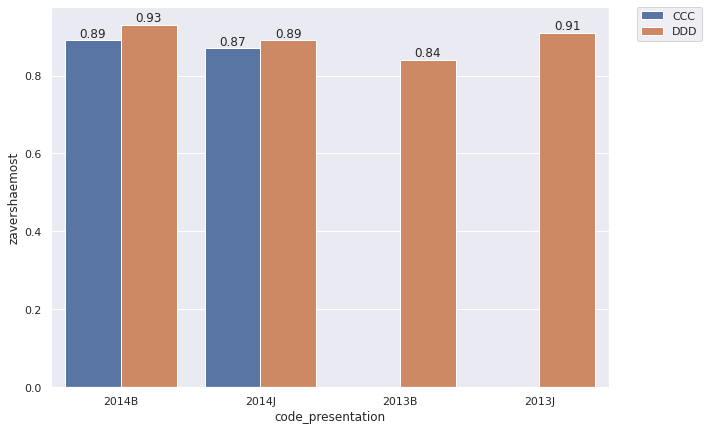

In [30]:
#Рисуем график
graph_module_pres = sns.barplot(x="code_presentation", y="zavershaemost", 
            data=gr_zavershaemost_split,hue="code_module")

#Отодвигаем легенду
graph_module_pres.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписываем цифры для каждого столбца
for container in graph_module_pres.containers:
    graph_module_pres.bar_label(container)

Вывод из графика: 
- Самый простой экз – DDD, 2014B  
- Самый сложный экз – DDD, 2013B  

### Самый трудный / простой экз – по семестрам

In [31]:
#Подсчет общего кол-во сдач экзамена по каждому семестру
number_code = examin_data_new.query('assessment_type == "Exam"') \
    .groupby('code_presentation')['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

#Подсчет успешного кол-во сдач экзамена по каждому семестру
success_code = examin_data_new.query('assessment_type == "Exam" & score >= 40') \
    .groupby('code_presentation')['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

#Связываем дата-сеты
gr_zavershaemost_code = number_code.merge(success_code, on = ['code_presentation', 'assessment_type'])

#Пишем формулу для завершаемости 
gr_zavershaemost_code['zavershaemost'] = round(gr_zavershaemost_code.success / gr_zavershaemost_code.num,2)

gr_zavershaemost_code

,code_presentation,assessment_type,num,success,zavershaemost
0,2013B,Exam,602,504,0.84
1,2013J,Exam,967,878,0.91
2,2014B,Exam,1271,1149,0.90
3,2014J,Exam,2118,1861,0.88


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


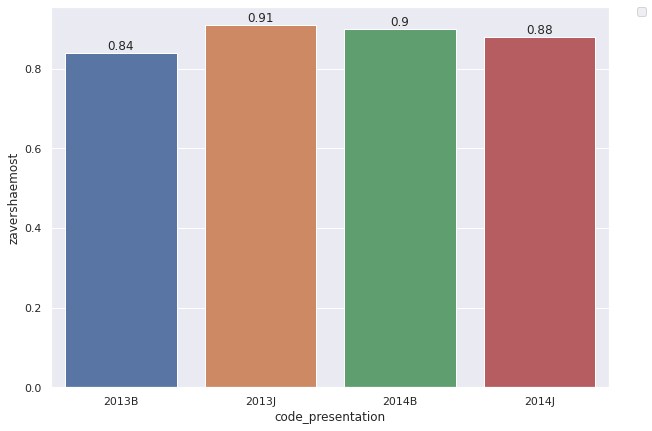

In [32]:
#Рисуем график
graph_pres = sns.barplot(x="code_presentation", y="zavershaemost", 
            data=gr_zavershaemost_code)

#Отодвигаем легенду
graph_pres.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписываем цифры для каждого столбца
for container in graph_pres.containers:
    graph_pres.bar_label(container)

Вывод из графика: 
- Самый простой экз  – 2013J   
- Самый сложный экз – 2013B

### Самый трудный / простой экз – предмет

In [87]:
number_module = examin_data_new.query('assessment_type == "Exam"') \
    .groupby('code_module')['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

success_module = examin_data_new.query('assessment_type == "Exam" & score >= 40') \
    .groupby('code_module')['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

gr_zavershaemost_module = number_module.merge(success_module, on = ['code_module', 'assessment_type'])

gr_zavershaemost_module['zavershaemost'] = round(gr_zavershaemost_module.success / gr_zavershaemost_module.num,2)

gr_zavershaemost_module

,code_module,assessment_type,num,success,zavershaemost
0,CCC,Exam,1915,1683,0.88
1,DDD,Exam,3043,2709,0.89


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


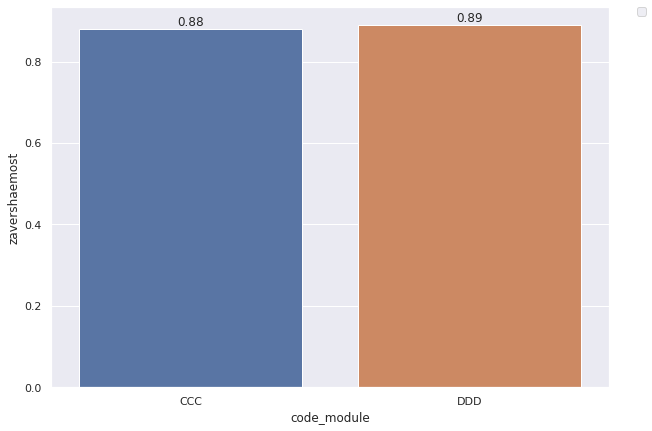

In [34]:
#Рисуем график
graph_module = sns.barplot(x="code_module", y="zavershaemost", 
            data=gr_zavershaemost_module)

#Отодвигаем легенду
graph_module.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписываем цифры для каждого столбца
for container in graph_module.containers:
    graph_module.bar_label(container)

Вывод из графика:  
- Самый простой экз – DDD   
- Самый сложный экз – CCC

#### Исходя из результатов, можно предположить, что предметы и семестры легкие, потому что оверол завершаемость >= 80 

Но, может в этих данных есть стат. значимые различия и даже маленькое отклонение в меньшее значение делает экзамен сложным

Давайте попробуем провести хи-тест, чтобы проверить связь успешной сдачи экзамена и семестра | предмета

#### Преобразуем данные 

In [33]:
#Создаем дамми-переменную: 1 - успех, 0 - неуспешная сдача экзааменаа
examin_data_new['success'] = np.where(examin_data_new['score'] >= 40, 1, 0).tolist()

#Содздаем отдельный дата-сет для хи-теста
chi_square_data = examin_data_new.query('assessment_type == "Exam" & score == score')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Хи тест для предметов 

In [34]:
#Создаем кросс-таблицу
crosstable_code_module = pd.crosstab(chi_square_data['code_module'], chi_square_data['success'])

#Считаем метрики
chi2, p, dof, ex = chi2_contingency(crosstable_code_module, correction=True)
print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")

Chi2 result of the contingency table: 1.3969537223386934, p-value: 0.2372342833682606


Результат стат. не значим. Мы не можем отклонить H0

### Хи тест для семестров

In [35]:
#Создаем кросс-таблицу
crosstable_semestr = pd.crosstab(chi_square_data['code_presentation'], chi_square_data['success'])

#Считаем метрики
chi2, p, dof, ex = chi2_contingency(crosstable_semestr, correction=True)
print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")

Chi2 result of the contingency table: 23.98889166795387, p-value: 2.5113725658163416e-05


Результат стат. незначим. Даже без проведения Post-hoc (он нужен, т.к. у нас много групп)

### Хи тест для семестров и предметов 

In [36]:
#Создаем одну колонку из переменных предмета и семестра
chi_square_data["module_semestr"] = chi_square_data["code_module"] + "_" + chi_square_data["code_presentation"]

#Создаем кросс-таблицу
crosstable_semestr_module = pd.crosstab(chi_square_data['module_semestr'], chi_square_data['success'])

#Считаем метрики
chi2, p, dof, ex = chi2_contingency(crosstable_semestr_module, correction=True)
print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")

Chi2 result of the contingency table: 29.085686199963515, p-value: 2.230712179094228e-05


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Результат стат. незначим. Даже без проведения Post-hoc (он нужен, т.к. у нас много групп)

## Общий вывод по данным 

1. Среди студентов, кто сдавал экзамены:
    - никто их не пересдавал
    - все пришли на экзамен, кроме одного (он дропнулся)
    - из группы студентов, кто сдавал экзамены, некоторые успели проучится на том же предмете в другом семестре (но дропнулись на нем) 
    - из группы студентов, кто сдавал экзамены, некоторые успели проучится на другом предмете, но дропнулись на нем
    
    
2. Экзамены несложные, поскольку завершаемость достаточно высокая 


3. Успех в сдаче экзамена, возможно, не связан с предметом и семестром и их взаимодействием (поскольку во всех случаях хи-тест не смог отклонить нулевую гипотезу) 